# Region Perturbation POC

Compared to previous notebooks, this notebook should integrate inpainting for the first time as a perturbation technique to the pixel-flipping/region perturbation algorithm.

## LRP

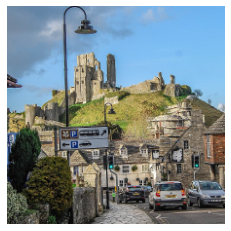

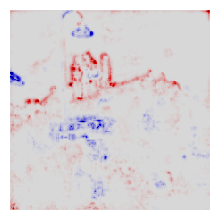

In [1]:
%load_ext autoreload
%autoreload 2

from typing import Callable, Dict, List, Tuple, Union

import numpy
import torch
import torchvision
from matplotlib import pyplot as plt

import lrp.plot
import lrp.rules as rules
from lrp import image
from lrp.core import LRP
from lrp.filter import LayerFilter
from lrp.rules import LrpEpsilonRule, LrpGammaRule, LrpZBoxRule, LrpZeroRule
from lrp.zennit.types import AvgPool, Linear

# Input data
# Image is in RGB mode with range [0,1]
img_bgr_hwc_float_0_1: numpy.array = image.load_img_norm_zero_one('../../data/castle.jpg')
X = lrp.norm.ImageNetNorm.transform(img_bgr_hwc_float_0_1)
# Simulate batch by adding a new dimension
X = torch.unsqueeze(X, 0)

plt.axis('off')
lrp.plot.plot_imagenet(X)

# Model
model = torchvision.models.vgg16(pretrained=True)
model.eval()

# Low and high parameters for zB-rule
batch_size: int = 1
shape: Tuple[int] = (batch_size, 3, 224, 224)

low: torch.Tensor = lrp.norm.ImageNetNorm.normalize(torch.zeros(*shape))
high: torch.Tensor = lrp.norm.ImageNetNorm.normalize(torch.ones(*shape))

# Init layer filter
vgg16_target_types: Tuple[type] = (Linear, AvgPool)
filter_by_layer_index_type: LayerFilter = LayerFilter(model)
filter_by_layer_index_type.set_target_types(vgg16_target_types)

name_map: List[Tuple[List[str], rules.LrpRule, Dict[str, Union[torch.Tensor, float]]]]
name_map = [
    (filter_by_layer_index_type(lambda n: n == 0), LrpZBoxRule, {'low': low, 'high': high}),
    (filter_by_layer_index_type(lambda n: 1 <= n <= 16), LrpGammaRule, {'gamma': 0.25}),
    (filter_by_layer_index_type(lambda n: 17 <= n <= 30), LrpEpsilonRule, {'epsilon': 0.25}),
    (filter_by_layer_index_type(lambda n: 31 <= n), LrpZeroRule, {}),
]

lrp_instance: LRP = LRP(model)
lrp_instance.convert_layers(name_map)
R: torch.Tensor = lrp_instance.relevance(X)
lrp_instance.heatmap(R, width=2, height=2)

## Region Perturbation

Try Region Perturbation with inpainting enabled.

In [2]:
# %%script false --no-raise-error

# Parameters for cell: input_nchw, relevance_scores_nchw, lrp_instance
from pf.perturbation_modes.constants import PerturbModes
from pf.pixel_flipping import PixelFlipping

perturbation_steps: int = 11
perturbation_size: int = 8

pixel_flipping: PixelFlipping = PixelFlipping(perturbation_steps=perturbation_steps,
                                              perturbation_size=perturbation_size,
                                              perturb_mode=PerturbModes.INPAINTING)
input_nchw: torch.Tensor = X.clone().detach()

# Enable reproducibility
torch.manual_seed(42)

relevance_scores_nchw: torch.Tensor = R.clone().detach()

# Function should return the (single-class) classification score for the given input to measure the difference between flips.
forward_pass: Callable[[torch.Tensor], float] = lambda input_nchw: lrp_instance.model(input_nchw)[:,483]

# Run Pixel-Flipping algorithm
pixel_flipping(input_nchw, relevance_scores_nchw, forward_pass)

Finished '_flip' in 1.1419 secs
Finished '_flip' in 1.1032 secs
Finished '_flip' in 1.1019 secs
Finished '_flip' in 0.9700 secs
Finished '_flip' in 0.9857 secs
Finished '_flip' in 0.9768 secs
Finished '_flip' in 0.9764 secs
Finished '_flip' in 0.9906 secs
Finished '_flip' in 1.0065 secs
Finished '_flip' in 1.0174 secs
Finished '__call__' in 11.2831 secs


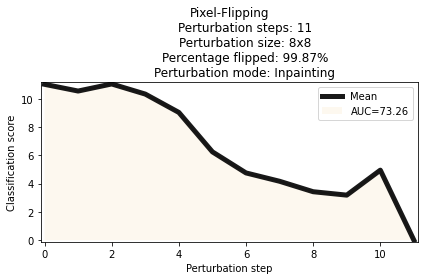

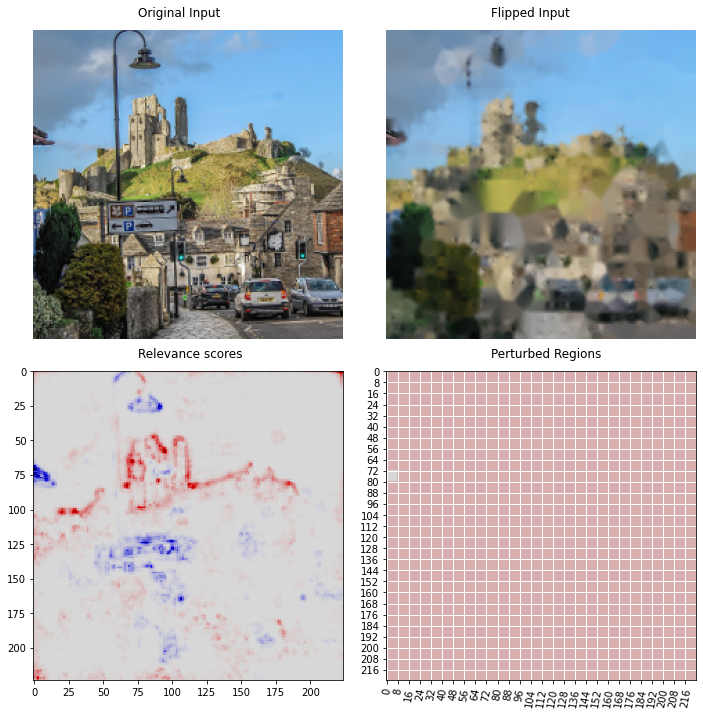

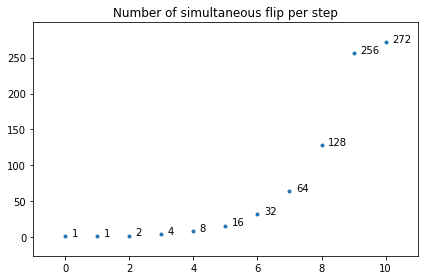

In [5]:
pixel_flipping.plot_class_prediction_scores()
pixel_flipping.plot_image_comparison()
pixel_flipping.plot_number_of_flips_per_step()